# Doing an exploration on recent disaster tweets for all disaster types - determine if one disaster dominates in certain class/category

In [1]:
import pandas as pd
import pickle

import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import networkx as nx 
import nx_altair as nxa
from collections import Counter
import warnings
import scipy.stats as stats

from tools import extract_assign_location_per_kind, disaster_title, topNlocations, top_locations, \
                    sampleNtweets, top_locations_tweets, show_top_locations, get_top_locations_flatten, \
                    get_location_graph_data, build_network, get_layout, plot_disaster_mentions, is_intersect, \
                    show_tweets_locations, top_location_pairs, plot_class_boxplot, f_test, ks_test

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 280)

## Define any upstream dependencies

In [2]:
upstream = [
    'vectorizer',
    'category_classification_models',
    'recent_tweets_wildfire',
    'recent_tweets_earthquake',
    'recent_tweets_flood',
    'recent_tweets_hurricane'
]
random_seed = None
disaster_kinds = None

In [3]:
# Parameters
random_seed = 42
disaster_kinds = [
    "recent_tweets_wildfire",
    "recent_tweets_hurricane",
    "recent_tweets_flood",
    "recent_tweets_earthquake",
]
upstream = {
    "vectorizer": {
        "nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/vectorizer.ipynb",
        "vectorizer": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/vectorizer.pkl",
        "vocab": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/vocab.pkl",
    },
    "category_classification_models": {
        "nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/category_classification_models.ipynb",
        "model_lr": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/model_lr.pkl",
        "model_rf": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/model_rf.pkl",
        "model_nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/model_nb.csv",
        "model_votingc": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/model_votingc.csv",
    },
    "recent_tweets_earthquake": {
        "nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/recent_tweets_earthquake.ipynb",
        "file": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/recent_tweets_earthquake.csv",
    },
    "recent_tweets_wildfire": {
        "nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/recent_tweets_wildfire.ipynb",
        "file": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/recent_tweets_wildfire.csv",
    },
    "recent_tweets_hurricane": {
        "nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/recent_tweets_hurricane.ipynb",
        "file": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/recent_tweets_hurricane.csv",
    },
    "recent_tweets_flood": {
        "nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/recent_tweets_flood.ipynb",
        "file": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/recent_tweets_flood.csv",
    },
}
product = {
    "nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/tweets_timeline_compare.ipynb"
}


In [4]:
disaster_kind_names = [disaster_title(disaster_kind) for disaster_kind in disaster_kinds]
disaster_kind_names

['Wildfire', 'Hurricane', 'Flood', 'Earthquake']

## Load the sample of recent tweets for all disaster types

In [5]:
df_tweets = None

for disaster_kind in disaster_kinds:
    _df = pd.read_csv(upstream[disaster_kind]['file'])
    _df['disaster_kind'] = disaster_title(disaster_kind)
    
    if df_tweets is None:
        df_tweets = _df
    else:
        df_tweets = df_tweets.append(_df, ignore_index=True)

print('Number of tweets: ', df_tweets.shape[0])
df_tweets.sample(5)

Number of tweets:  537642


,author_id,tweet_text,created_at,hashtags,users,disaster_kind
229482,14225963,"RT @DeborahDian: Nearly everyone has to evacuate sometime in their lives, whether because of a fire, hurricane, flooding or other weather e…",2022-08-03 01:35:58+00:00,[],['DeborahDian'],Hurricane
7490,1630567249,RT @JenDowlingNews: Firefighters are still on the scene of the Lind fire this morning. It looks like they are continuing to assess the fir…,2022-08-05 15:03:00+00:00,[],['JenDowlingNews'],Wildfire
1907,1501987706733137937,"RT @KREM2: According to the state fire marshal's office, homes and crops, as well as railroad and critical infrastructure are being threate…",2022-08-05 14:54:51+00:00,[],['KREM2'],Wildfire
459634,1112896007774371840,"2.20 magnitude earthquake occurred at Hawaii, HI, United States on 2022-08-03 03:57:13 UTC\nMap: https://t.co/muyrm6eFoC\n#earthb0t #earthquake #Hawaii #HI #UnitedStates #noaa #greatshakeout #LetsBeSafe #OpenData #data https://t.co/WbIirj3wkY",2022-08-03 04:12:23+00:00,"['earthb0t', 'earthquake', 'Hawaii', 'HI', 'UnitedStates', 'noaa', 'greatshakeout', 'LetsBeSafe', 'OpenData', 'data']",[],Earthquake
232380,904740870817120256,https://t.co/QtM4PmeaQA EVACUATION ZONE CHANGES Pinellas County Emergency Management updated evacuation zones for 2022 hurricane season based on latest surge data models from National Hurricane Center elevation data from the County. Check zones at https://t.co/GSLiOLhHpc,2022-08-01 20:19:21+00:00,[],[],Hurricane


## Predict the class labels - add class_label to all the tweets 

In [6]:
# Get the vectorizer
with open(upstream["vectorizer"]["vectorizer"], 'rb') as f:
    vectorizer = pickle.load(f)

In [7]:
# Get the classification model
with open(upstream["category_classification_models"]["model_lr"], 'rb') as f:
    classifier = pickle.load(f)

In [8]:
%%time
# Predict the class labels
class_label = classifier.predict(vectorizer.transform(df_tweets['tweet_text']))
df_tweets['class_label'] = class_label

df_tweets.sample(5)

CPU times: user 2min 8s, sys: 432 ms, total: 2min 9s
Wall time: 2min 9s


,author_id,tweet_text,created_at,hashtags,users,disaster_kind,class_label
331273,1337639908224114693,He had donated a huge amount of money towards Nagland and Kerala flood relief in 2018.Everyone always remember your kindness.\n\nSSR Worked 4 SelfActualisation https://t.co/QCHPFHnb8I,2022-08-03 14:41:19+00:00,[],[],Flood,rescue_volunteering_or_donation_effort
316564,2871336331,"RT @DSSNewsUpdates: Risking their own lives, #DSS volunteers saved lives &amp; livelihood from flood in Sirsa.Acres of land submerged due to he…",2022-08-04 02:17:10+00:00,['DSS'],['DSSNewsUpdates'],Flood,rescue_volunteering_or_donation_effort
44173,1106927792099418112,RT @ECOWARRIORSS: Get ready for a world of fire - its just beginning \nTens of thousands of people around world have been evacuated this sum…,2022-08-05 01:50:23+00:00,[],['ECOWARRIORSS'],Wildfire,displaced_people_and_evacuations
474640,1392185571359870978,"RT @cnnphilippines: JUST IN: A magnitude 5.8 earthquake hits waters off Manay, Davao Oriental.\n\nPhivolcs says aftershocks are expected.\n\nFu…",2022-08-03 02:37:59+00:00,[],['cnnphilippines'],Earthquake,other_relevant_information
74098,1507767572363628554,"RT @BNNBreaking: JUST IN: A 26-year-old man, identified as Cory Allan Martin, was arrested in Utah, on suspicion that he started wildfire w…",2022-08-03 21:38:44+00:00,[],['BNNBreaking'],Wildfire,other_relevant_information


## Plot the intensity for each disaster kind, each class

In [9]:
class_labels = [
    'displaced_people_and_evacuations',
    'injured_or_dead_people',
    'rescue_volunteering_or_donation_effort',
    'requests_or_urgent_needs',
    'sympathy_and_support',
    'infrastructure_and_utility_damage',
    'caution_and_advice'
]

### Aggregate the disaster types and categories in 8-hour groups

In [10]:
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'], errors='coerce')
df_plot = df_tweets.copy()

df_plot['created_at'] = df_plot['created_at'].dt.floor('8H') # Round to 8 hours
df_plot['count'] = 1
df_group_plot = df_plot[['created_at', 'class_label', 'disaster_kind','count']].groupby(
    ['created_at', 'class_label', 'disaster_kind']
).count().reset_index()
df_group_plot['created_at'] = pd.to_datetime(df_group_plot['created_at'])
df_group_plot.sort_values(by='disaster_kind', inplace=True)
df_group_plot.head()

,created_at,class_label,disaster_kind,count
0,2022-07-31 08:00:00+00:00,caution_and_advice,Earthquake,232
260,2022-08-03 00:00:00+00:00,injured_or_dead_people,Earthquake,145
263,2022-08-03 00:00:00+00:00,not_humanitarian,Earthquake,75
267,2022-08-03 00:00:00+00:00,other_relevant_information,Earthquake,7384
271,2022-08-03 00:00:00+00:00,requests_or_urgent_needs,Earthquake,85


### Looking at all the disaters at once does not have any indication which one dominates. Visually, when no class is considered, noone dominates.

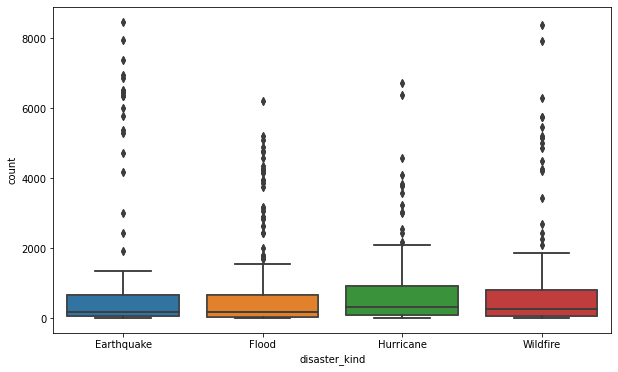

In [11]:
plot_class_boxplot(df_group_plot)

### Perform an f-test of the above, to determine if the means are different - the f-statistic is low and the pvalue is high, which confirms that no disaster kind stands up as compared to the others

In [12]:
f_test(df_group_plot)

F_onewayResult(statistic=0.3869087889615666, pvalue=0.7624738994702899)

### The outcome is the same when we try a KS-test - no one disaster dominates the tweet sample

In [13]:
ks_test(df_group_plot)

(None, None)

### Trying displaced_people_and_evacuations - visually 'Wildfires' tweets are more dominant

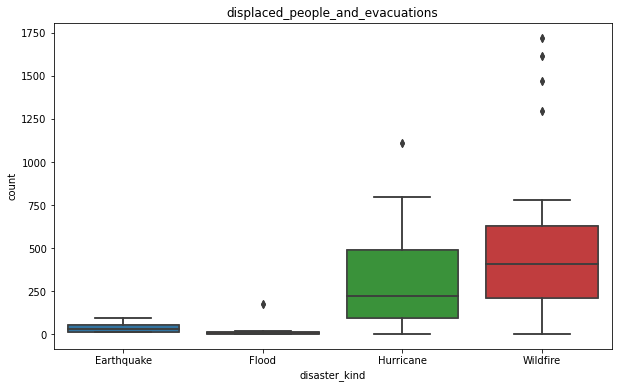

In [14]:
plot_class_boxplot(df_group_plot, 'displaced_people_and_evacuations')

### The f-statistic is relatively low - below 10, but the pvalue is also low, so there is a chance at least one tweet distribution is different, however, not that statistically significant 

In [15]:
f_test(df_group_plot, class_labels=['displaced_people_and_evacuations'])

F_onewayResult(statistic=6.998888294867653, pvalue=0.00043411742534776675)

In [16]:
ks_test(df_group_plot, class_labels=['displaced_people_and_evacuations'])

(None, None)

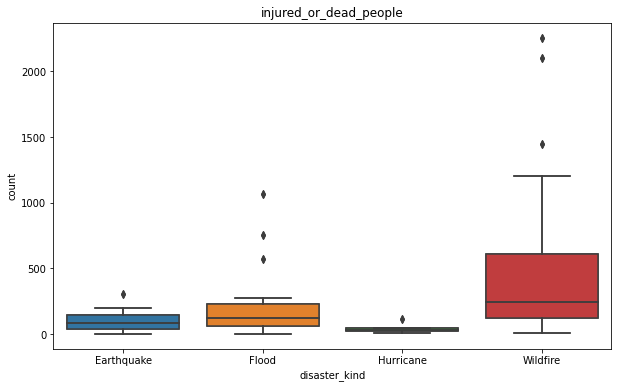

In [17]:
plot_class_boxplot(df_group_plot, 'injured_or_dead_people')

In [18]:
f_test(df_group_plot, class_labels=['injured_or_dead_people'])

F_onewayResult(statistic=5.201780020635175, pvalue=0.002837749650474971)

In [19]:
ks_test(df_group_plot, class_labels=['injured_or_dead_people'])

(None, None)

### For rescue_volunteering_or_donation_effort, the 'flood' disasters clearly dominate as shown visually and statistically 

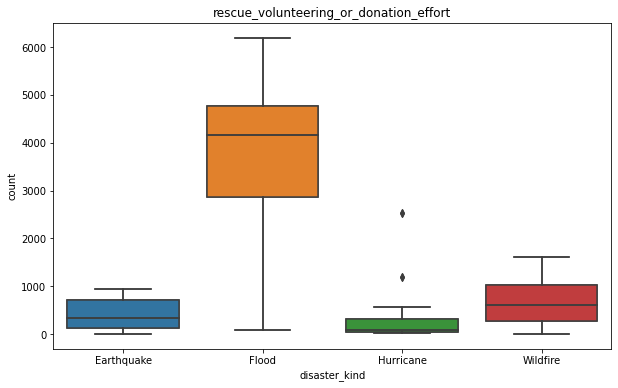

In [20]:
plot_class_boxplot(df_group_plot, 'rescue_volunteering_or_donation_effort')

In [21]:
f_test(df_group_plot, class_labels=['rescue_volunteering_or_donation_effort'])

F_onewayResult(statistic=63.466941273877204, pvalue=1.1924304959724865e-20)

In [22]:
ks_test(df_group_plot, class_labels=['rescue_volunteering_or_donation_effort'])

('Flood',
 [3.396884814555207e-08, 5.429149940086322e-08, 3.046866711808434e-09])

### No clear dominant disaster kind for requests_or_urgent_needs

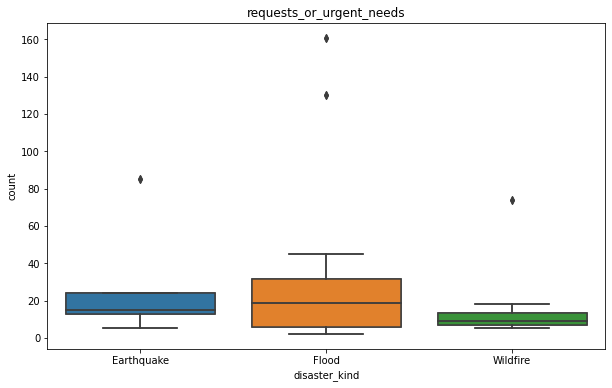

In [23]:
plot_class_boxplot(df_group_plot, 'requests_or_urgent_needs')

In [24]:
f_test(df_group_plot, class_labels=['requests_or_urgent_needs'])

F_onewayResult(statistic=0.5748157084043445, pvalue=0.5688858588003824)

In [25]:
ks_test(df_group_plot, class_labels=['requests_or_urgent_needs'])

(None, None)

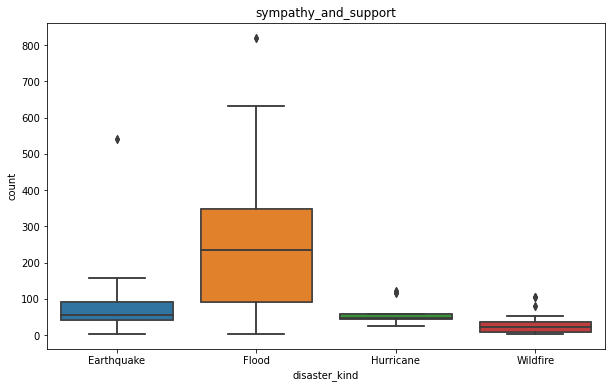

In [26]:
plot_class_boxplot(df_group_plot, 'sympathy_and_support')

In [27]:
f_test(df_group_plot, class_labels=['sympathy_and_support'])

F_onewayResult(statistic=10.298553326159121, pvalue=1.360213044730053e-05)

In [28]:
ks_test(df_group_plot, class_labels=['sympathy_and_support'])

('Flood',
 [2.7845314879217286e-05, 0.0023585609792506346, 0.0007671189660839997])

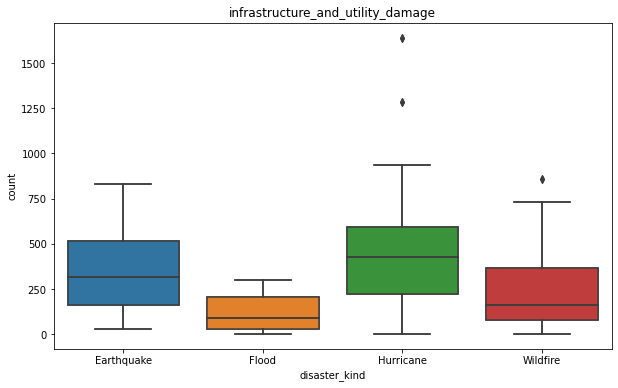

In [29]:
plot_class_boxplot(df_group_plot, 'infrastructure_and_utility_damage')

In [30]:
f_test(df_group_plot, class_labels=['infrastructure_and_utility_damage'])

F_onewayResult(statistic=6.906167024695891, pvalue=0.0003486808833049537)

In [31]:
ks_test(df_group_plot, class_labels=['infrastructure_and_utility_damage'])

(None, None)

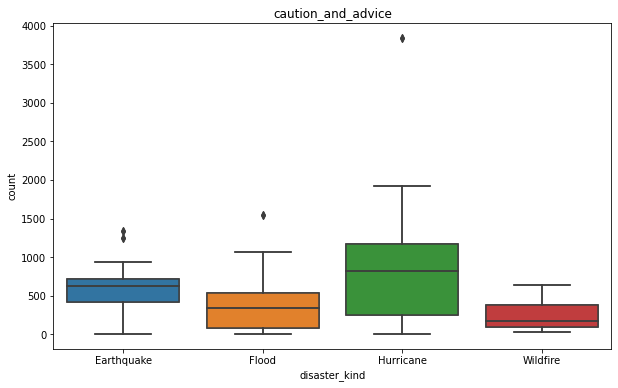

In [32]:
plot_class_boxplot(df_group_plot, 'caution_and_advice')

In [33]:
f_test(df_group_plot, class_labels=['caution_and_advice'])

F_onewayResult(statistic=5.927316603235517, pvalue=0.0010720839336386381)

In [34]:
ks_test(df_group_plot, class_labels=['caution_and_advice'])

('Hurricane',
 [0.00037629214474702027, 0.014168473566567592, 0.04740986150281502])

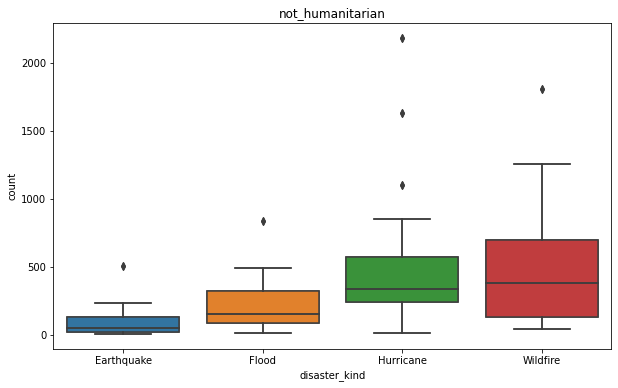

In [35]:
plot_class_boxplot(df_group_plot, 'not_humanitarian')

In [36]:
f_test(df_group_plot, class_labels=['not_humanitarian'])

F_onewayResult(statistic=5.937505122603691, pvalue=0.0010787301870656097)

In [37]:
ks_test(df_group_plot, class_labels=['not_humanitarian'])

(None, None)

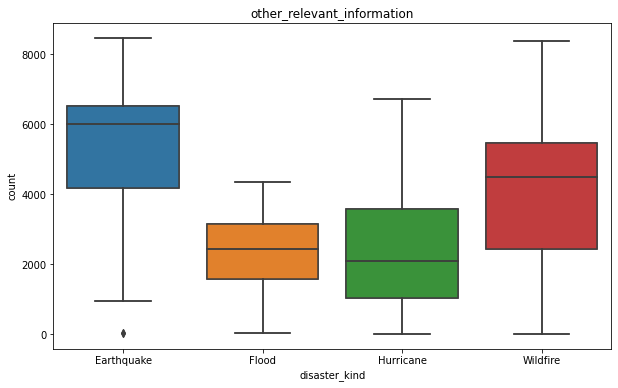

In [38]:
plot_class_boxplot(df_group_plot, 'other_relevant_information')

In [39]:
f_test(df_group_plot, class_labels=['other_relevant_information'])

F_onewayResult(statistic=10.007689381829522, pvalue=1.1550199801339669e-05)

In [40]:
ks_test(df_group_plot, class_labels=['other_relevant_information'])

('Earthquake',
 [0.02054427331788651, 0.00021928185467383614, 3.395576891283797e-06])

### Identify class labels for active disasters - these are more distressed tweets

In [41]:
class_labels_active = [
    'displaced_people_and_evacuations',
    'injured_or_dead_people',
]

### The visualization and the statistic tests clearly shows the Wildfires dominate for this particular week

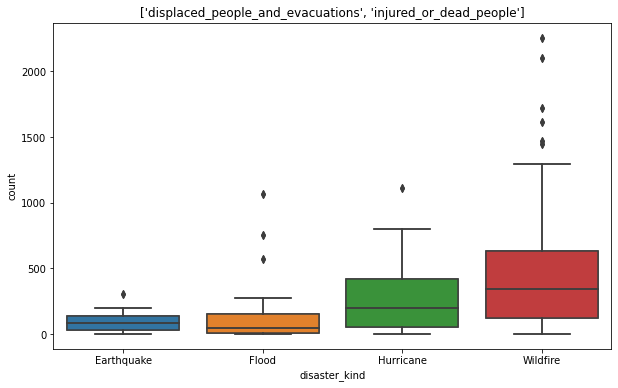

In [42]:
plot_class_boxplot(df_group_plot[df_group_plot['class_label'].isin(class_labels_active)], title=class_labels_active)

In [43]:
f_test(df_group_plot, class_labels=class_labels_active)

F_onewayResult(statistic=10.35071997380027, pvalue=3.960570565233521e-06)

In [44]:
ks_test(df_group_plot, class_labels=class_labels_active)

('Wildfire',
 [0.07322472520068853, 5.2459936908087666e-05, 2.3038948480462642e-07])

### Identify class labels for past/calm down disasters - the danger has already passed, the community deals with the consequences of the event

In [45]:
class_labels_past = [
    'rescue_volunteering_or_donation_effort',
    'requests_or_urgent_needs',
    'sympathy_and_support',
]

### Visually and statistically 'flood' disasters dominate for this week

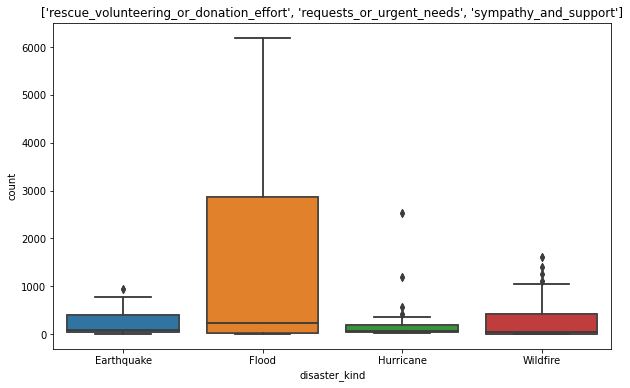

In [46]:
plot_class_boxplot(df_group_plot[df_group_plot['class_label'].isin(class_labels_past)], title=class_labels_past)

In [47]:
f_test(df_group_plot, class_labels=class_labels_past)

F_onewayResult(statistic=11.950317300994135, pvalue=3.715889348149974e-07)

In [48]:
ks_test(df_group_plot, class_labels=class_labels_past)

('Flood', [0.007012714471607445, 0.014540857905105333, 0.006384398236281075])

### Show the disasters over time as timeseries

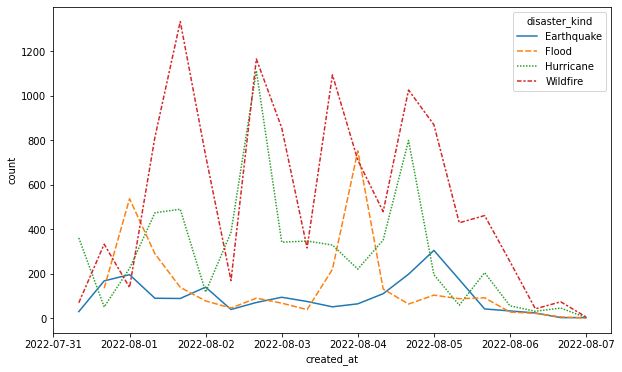

In [49]:
plt.figure(figsize = (10,6))
sns.lineplot(x='created_at', y='count', hue="disaster_kind", style="disaster_kind", ci=None,
             data=df_group_plot[df_group_plot['class_label'].isin(class_labels_active)]);

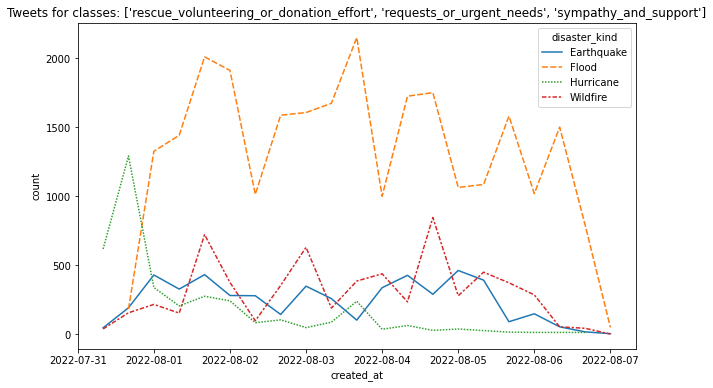

In [50]:
plt.figure(figsize = (10,6))
sns.lineplot(x='created_at', y='count', hue="disaster_kind", style="disaster_kind", ci=None,
             data=df_group_plot[df_group_plot['class_label'].isin(class_labels_past)]).set(
    title='Tweets for classes: ' + str(class_labels_past)
);

### A simple computation allows us to also compare the means and standard deviations for the disaster kinds - by inspecting these, we can see which one is higher, even we don't have a statistical proof  

In [51]:
df_group_plot[df_group_plot['class_label'].isin(class_labels_active)].groupby('disaster_kind').agg(
    {
        "count": ['min', 'max', 'mean', 'std']
    }
)

count                              
                min   max        mean         std
disaster_kind                                    
Earthquake        3   305   90.555556   73.769565
Flood             1  1069  138.545455  234.770512
Hurricane         3  1112  274.444444  289.212104
Wildfire          1  2257  552.951220  603.700462

In [52]:
df_group_plot[df_group_plot['class_label'].isin(class_labels_past)].groupby('disaster_kind').agg(
    {
        "count": ['min', 'max', 'mean', 'std']
    }
)

count                                
                min   max         mean          std
disaster_kind                                      
Earthquake        3   946   241.325581   278.752128
Flood             2  6201  1354.982759  1910.837591
Hurricane        13  2536   246.740741   519.908394
Wildfire          1  1611   293.372549   436.783011